<a href="https://colab.research.google.com/github/CorpuzKB/PML-Advance-Topics-notebooks/blob/main/HMM_Baum_Welch_(EM)__TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baum-Welch (EM) Algorithm for HMM

The **EM_HMM_Categorical** class applies the Baum-Welch (EM) algorithm for parameter learning of HMMs with a discrete likelihood for the emission model. Implemented from the book, [Probabilistic Machine Learning: Advanced Topics (Murphy K., 2023)](https://probml.github.io/pml-book/book2.html).

Given the observations $y_{1},\cdots, y_{T}$, we aim to find:
\begin{align*}
A &= \Pr(\mathbf z_{t}|\mathbf z_{t-1}) \\
B &= \Pr(\mathbf y|\mathbf z) \\
\pi &= \Pr(\mathbf z_1)
\end{align*}


---


At iteration $t-1$, we have:

1.   Parameters $\mathbf \theta_{t-1} = (A_{t-1}, B_{t-1}, \pi_{t-1})$
2.   Smoothed latent posteriors $\gamma = \Pr(\mathbf z|\mathbf y, \theta_{t-1})\in \mathbb{R}^{B\times N\times K\times 1}$
3.   Two slice marginals $\xi =\Pr(\mathbf z_{t-1}, \mathbf z_{t}|\mathbf y, \theta_{t-1})\in \mathbb{R}^{B\times N\times K\times K}$
4. Observations $\mathbf y\in \mathbb{R}^{B\times N\times 1}$

where $B, N, K$ denote the batch dimension, time steps, and number of latent states respectively. The Baum-Welch (EM) algorithm is then iterated as follows:


> **E Step**
\begin{align*}
\mathop{\mathbb{E}}[N_K^1] &= \sum_B \gamma\ [:, 0, ...]\\
\mathop{\mathbb{E}}[N_K] &= \sum_B\sum_N \gamma\ [:, 1, ...]\\
\mathop{\mathbb{E}}[N_{JK}] &= \sum_B\sum_N \xi\\
\text{for } v\in \text{dim}(B)\\
\mathop{\mathbb{E}}[M_{Kv}] &= \sum_B\sum_N \gamma \cdot \mathbb{I}\ [y_n=v]
\end{align*}
Note that the summation is done with respect to matrices/vectors of each respective batch.

>**M step** 
>
>Update $\mathbf \theta_{t} = (A_{t}, B_{t}, \pi_{t})$ where:
\begin{align*}
A_t &= \text{normalize}(\mathop{\mathbb{E}}[N_{JK}])\\
B_t &= \text{normalize}(\mathop{\mathbb{E}}[M_{KV}])\\
\pi_t &= \text{normalize}(\mathop{\mathbb{E}}[N_K^1])\\
\end{align*}
where $\text{normalize}()$ corresponds to division by their respective number of occurences, times, etc. that will make $\theta_{t}$ valid stochastic vectors/matrices.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats

tfd = tfp.distributions
sns.set(rc={"figure.dpi":80, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
set_matplotlib_formats('retina')

## Baum-Welch (EM)

In [51]:
class EM_HMM:
  def __init__(self, inference_module, EM_step, transition_distribution, emission_distribution, emission_params, initial_distribution):
    self.inference_module = inference_module
    self.emission_distribution = emission_distribution
    self.EM_step = EM_step
    self.parameters = {
        "transition_distribution": transition_distribution,
        "emission_params": emission_params,
        "initial_distribution": initial_distribution,
        "Q": tf.constant([0.0])
    }
    
  def iter_print(self, curr_iter, LL_t, verbose):
    if verbose: tf.print('\nIteration {}:\n A:\n{}\n\n B:\n{}\n\n π:\n{}'.format(curr_iter, *self.parameters.values()))
    tf.print('Iteration {}:\tECDLL = {}'.format(curr_iter, LL_t))

  def normalize(self, x, dim):
    return x / tf.reduce_sum(x, dim, keepdims=True)

  def expeted_CDLL(self, transition_distribution, emission_params, initial_distribution, smoothed, local_evidence, E_N1, E_NJK):
    Q_1 = tf.reduce_sum(E_N1 * tf.math.log(initial_distribution))
    Q_2 = tf.reduce_sum(E_NJK * tf.math.log(transition_distribution))
    Q_3 = tf.reduce_sum(smoothed * tf.math.log(local_evidence))
    return Q_1 + Q_2 + Q_3

  def __call__(self, observations, iter=1, verbose=False):
    Q = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in tf.range(iter):
      [transition_distribution, emission_params, initial_distribution, _] = self.parameters.values()
      transition_distribution, emission_params, initial_distribution, smoothed, local_evidence, E_N1, E_NJK = self.EM_step(
          self.inference_module, transition_distribution, self.emission_distribution, emission_params, initial_distribution, observations)
      Q_t = self.expeted_CDLL(transition_distribution, emission_params, initial_distribution, smoothed[..., 0], local_evidence[..., 0], E_N1, E_NJK)
      Q = Q.write(i, Q_t)
      self.parameters.update({
        "transition_distribution": transition_distribution,
        "emission_params": emission_params,
        "initial_distribution": initial_distribution,
      })
      self.iter_print(i + 1, Q_t, verbose)
    self.parameters.update({"Q": Q.stack()})

In [49]:
class EM_HMM_Categorical:
  def __call__(self, inference_module, transition_distribution, emission_distribution, emission_params, initial_distribution, observations):
    _, _, smoothed, _, two_slice_marginals, local_evidence = inference_module(
        transition_distribution, emission_distribution, emission_params, initial_distribution, observations)
    E_N1, E_NK, E_NJK, E_MKV = self.E_step(observations[..., 0], smoothed, two_slice_marginals, emission_params)
    transition_distribution, emission_params, initial_distribution = self.M_step(E_N1, E_NK, E_NJK, E_MKV, observations.shape[0])
    return transition_distribution, emission_params, initial_distribution, smoothed, local_evidence, E_N1, E_NJK

  @tf.function
  def E_step(self, observations, smoothed, two_slice_marginals, emission_params):
    E_MKV = tf.TensorArray(smoothed.dtype, size=0, dynamic_size=True)
    for v in tf.range(emission_params.shape[1]):
      indices = tf.where(observations == v)
      E_Mkv = tf.reduce_sum(tf.gather_nd(smoothed, indices), 0)[tf.newaxis, ...]
      E_MKV = E_MKV.write(v, E_Mkv)
    E_N1 = tf.reduce_sum(smoothed[:, 0], 0)
    E_NK = tf.reduce_sum(tf.reduce_sum(smoothed[:, 1:], 1), 0)
    E_NJK = tf.reduce_sum(tf.reduce_sum(two_slice_marginals, 1), 0)
    return E_N1, E_NK, E_NJK, tf.transpose(E_MKV.stack(), [1, 0, 2, 3])

  @tf.function
  def M_step(self, E_N1, E_NK, E_NJK, E_MKV, batch_dims):
    transition_distribution = E_NJK / tf.reduce_sum(E_NJK, -1, keepdims=True)
    emission_params = tf.transpose(tf.squeeze(E_MKV / E_NK))
    initial_distribution = E_N1 / batch_dims
    return transition_distribution, emission_params, initial_distribution

## Forward-Backwards
(See [HMM Inference](https://colab.research.google.com/drive/12JfQRmJOgHXOE1j-gXjfSDHlODpp3RVE?usp=sharing))

In [35]:
class HMM_Inference:
  def __call__ (self, transition_distribution, emission_distribution, emission_params, initial_distribution, observations):
    batch_dims, num_steps, num_states = observations.shape[0], observations.shape[1], transition_distribution.shape[0]
    emission_model = emission_distribution(emission_params)
    local_evidence = tf.exp(emission_model.log_prob(observations))[..., tf.newaxis]
    filtered, filtered_Z = self.Forward(transition_distribution, initial_distribution, local_evidence)
    smoothed, beta = self.Backward(filtered, filtered_Z, transition_distribution, local_evidence, batch_dims, num_steps, num_states)
    two_slice_marginals = self.marginals(filtered[:, 1:], beta[:, 1:], transition_distribution, local_evidence)
    return filtered[:, :-1], filtered_Z, smoothed[:, 1:], beta[:, 1:], two_slice_marginals, local_evidence

  def normalizing_constant(self, x):
    return tf.reduce_sum(x, -2, keepdims=True)

  @tf.function
  def Forward(self, transition_distribution, initial_distribution, local_evidence):
    filtered = tf.TensorArray(local_evidence.dtype, size=0, dynamic_size=True)
    filtered_Z = tf.TensorArray(local_evidence.dtype, size=0, dynamic_size=True)
    filtered_t = tf.broadcast_to(initial_distribution, local_evidence[:, 0].shape)
    filtered_Z_t = self.normalizing_constant(filtered_t)
    filtered_t = filtered_t / filtered_Z_t
    filtered = filtered.write(0, filtered_t)
    for i in tf.range(num_steps):
      filtered_t = local_evidence[:, i] * (tf.transpose(transition_distribution) @ filtered_t)
      filtered_Z_t = self.normalizing_constant(filtered_t)
      filtered_t = filtered_t / filtered_Z_t
      filtered = filtered.write(i + 1, filtered_t)
      filtered_Z = filtered_Z.write(i, filtered_Z_t)
    return tf.transpose(filtered.stack(), [1, 0, 2, 3]), tf.transpose(filtered_Z.stack(), [1, 0, 2, 3])

  @tf.function
  def Backward(self, filtered, filtered_Z, transition_distribution, local_evidence, batch_dims, num_steps, num_states):
    beta = tf.TensorArray(local_evidence.dtype, size=0, dynamic_size=True)
    beta_t = tf.fill([batch_dims, num_states, 1], 1.)
    beta = beta.write(num_steps, beta_t)
    for i in tf.range(num_steps - 1, -1, -1):
      beta_t = transition_distribution @ (local_evidence[:, i] * beta_t)
      beta_t = beta_t / filtered_Z[:, i]
      beta = beta.write(i, beta_t)  
    beta = tf.transpose(beta.stack(), [1, 0, 2, 3])
    smoothed = filtered * beta
    smoothed = smoothed / self.normalizing_constant(smoothed)
    return smoothed, beta

  @tf.function
  def marginals(self, filtered, beta, transition_distribution, local_evidence):
    shifted_filtered = filtered[:, :-1]
    shifted_beta = beta[:, 1:]
    shifted_local_evidence = local_evidence[:, 1:]
    unormalized_two_slice_marginals = transition_distribution * (shifted_filtered @ tf.transpose(shifted_local_evidence * shifted_beta, [0, 1, 3, 2]) )
    two_slice_marginals_Z = tf.reduce_sum(tf.reduce_sum(unormalized_two_slice_marginals, -1), -1, keepdims=True)
    return unormalized_two_slice_marginals / tf.broadcast_to(two_slice_marginals_Z[..., tf.newaxis], unormalized_two_slice_marginals.shape)

## HMM Observations Generator

In [36]:
@tf.function
def HMM_Generator(transition_matrix, emission_distribution, emission_params, states_probs_0, steps, batch_dims=1):
  state_t = tfd.Categorical(probs=tf.squeeze(states_probs_0)).sample([batch_dims, 1])
  transition_distribution = tfd.Categorical(probs=transition_matrix).sample([batch_dims, steps])
  observation_distribution = emission_distribution(emission_params).sample([batch_dims, steps])
  state = tf.TensorArray(state_t.dtype, size=0, dynamic_size=True)
  obs = tf.TensorArray(observation_distribution.dtype, size=0, dynamic_size=True, clear_after_read=False)
  for i in tf.range(steps):
    state_t = tf.gather_nd(transition_distribution[:, i], state_t, 1)[:, tf.newaxis]
    obs_t = tf.gather_nd(observation_distribution[:, i], state_t, 1)[:, tf.newaxis]
    state = state.write(i, state_t)
    obs = obs.write(i, obs_t)
  return tf.transpose(state.stack(), [1, 0, 2]), tf.transpose(obs.stack(), [1, 0, 2])

# Example 1. Casino HMM Parameter Learning

## Set the ground-truth parameters $(A_g, B_g, \pi_g)$

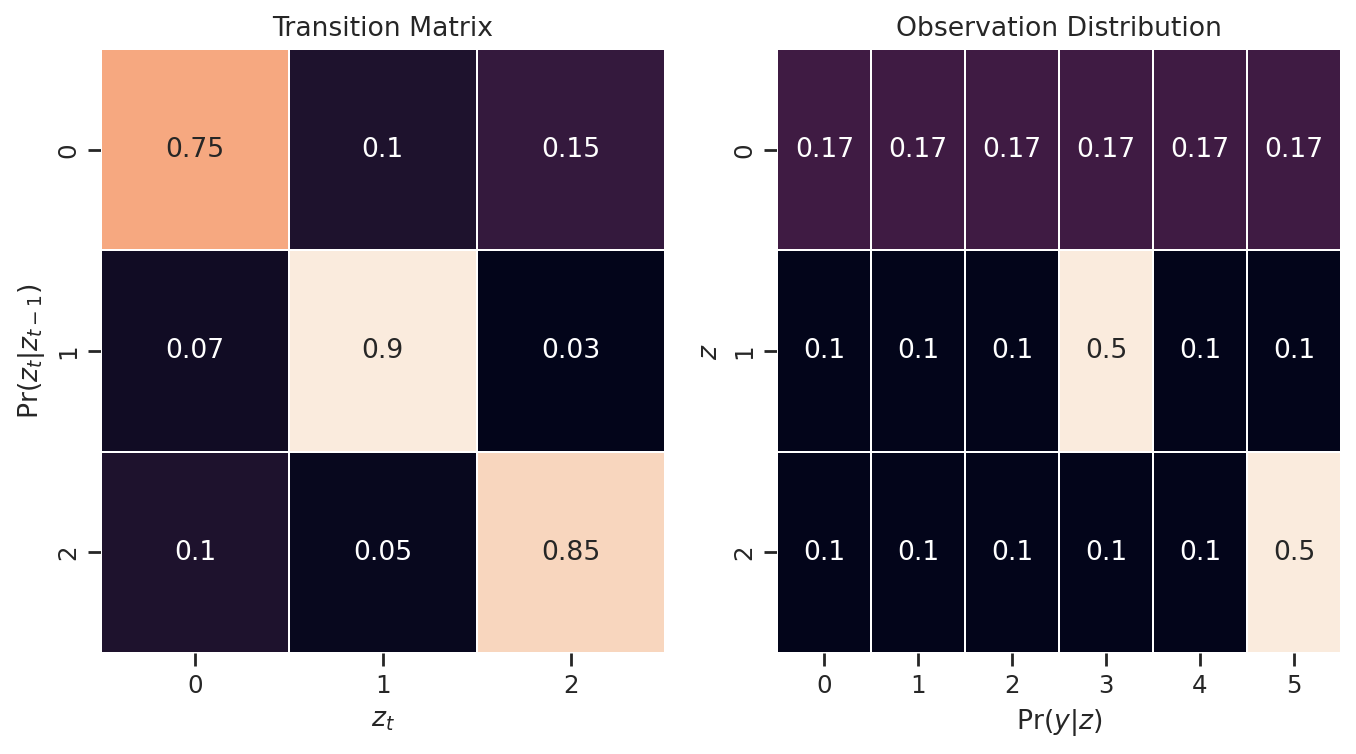

In [37]:
num_states = 3

initial_distribution = tf.constant([
    [0.5],
    [0.3], 
    [0.2]
])

transition_distribution = tf.constant([
    [0.75, 0.10, 0.15], 
    [0.07, 0.9, 0.03],
    [0.10, 0.05, 0.85]
])

emission_params = tf.stack([
    tf.squeeze(tf.constant(tf.fill([1, 6], 1/6))),
    tf.constant([1/10, 1/10, 1/10, 5/10, 1/10, 1/10]),
    tf.constant([*[1/10 for _ in range(5)], 5/10])
    ])

emission_distribution = lambda arg: tfd.Categorical(probs=arg)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(transition_distribution, annot=True, linewidth=.5, ax=axes[0], cbar=False)
sns.heatmap(emission_params, annot=True, linewidth=.5, ax=axes[1], cbar=False)
axes[0].set(xlabel='$z_{t}$', ylabel='$\Pr(z_{t}|z_{t-1})$', title='Transition Matrix')
axes[1].set(xlabel='$\Pr(y|z)$', ylabel='$z$', title='Observation Distribution'); plt.show()

## Generate $N$ bacthes of Casino HMM observations

In [38]:
num_batches = 10
num_steps = 5000
true_states, observations = HMM_Generator(transition_distribution, emission_distribution, emission_params, initial_distribution, num_steps, num_batches)
print('Generated {} batches of {}-step Casino HMM samples'.format(num_batches, num_steps), '\n')

Generated 10 batches of 5000-step Casino HMM samples 



## Perform paramater learning
Note that the Baum-Welch (EM) algorithm is sensitive to initial parameters as it has many local minima. Finding good starting points is not covered in this notebook.

In [ ]:
transition_distribution_init = tf.constant([
    [0.3, 0.4, 0.3],
    [0.4, 0.2, 0.4],
    [0.4, 0.2, 0.3]
])

emission_params_init = tf.constant([
    [0.2, 0.1, 0.2, 0.1, 0.2, 0.2],
    [0.1, 0.2, 0.1, 0.3, 0.1, 0.2],
    [0.2, 0.2, 0.1, 0.1, 0.1, 0.3]
])

initial_distribution_init = tf.constant([
    [0.4],
    [0.3],
    [0.3]
])

HMM_fit = EM_HMM(HMM_Inference(), EM_HMM_Categorical(), transition_distribution_init, emission_distribution, emission_params_init, initial_distribution_init)
HMM_fit(observations, iter=1250, verbose=False)

## Results

True parameters

[[0.75 0.1  0.15]
 [0.07 0.9  0.03]
 [0.1  0.05 0.85]]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.1        0.1        0.1        0.5        0.1        0.1       ]
 [0.1        0.1        0.1        0.1        0.1        0.5       ]]

[[0.5]
 [0.3]
 [0.2]] 


Learned parameters 

[[0.79 0.08 0.12]
 [0.04 0.91 0.05]
 [0.07 0.06 0.87]]

[[0.17 0.18 0.18 0.15 0.15 0.16]
 [0.1  0.1  0.1  0.49 0.11 0.1 ]
 [0.1  0.1  0.1  0.1  0.11 0.49]]

[[0.32]
 [0.32]
 [0.36]] 




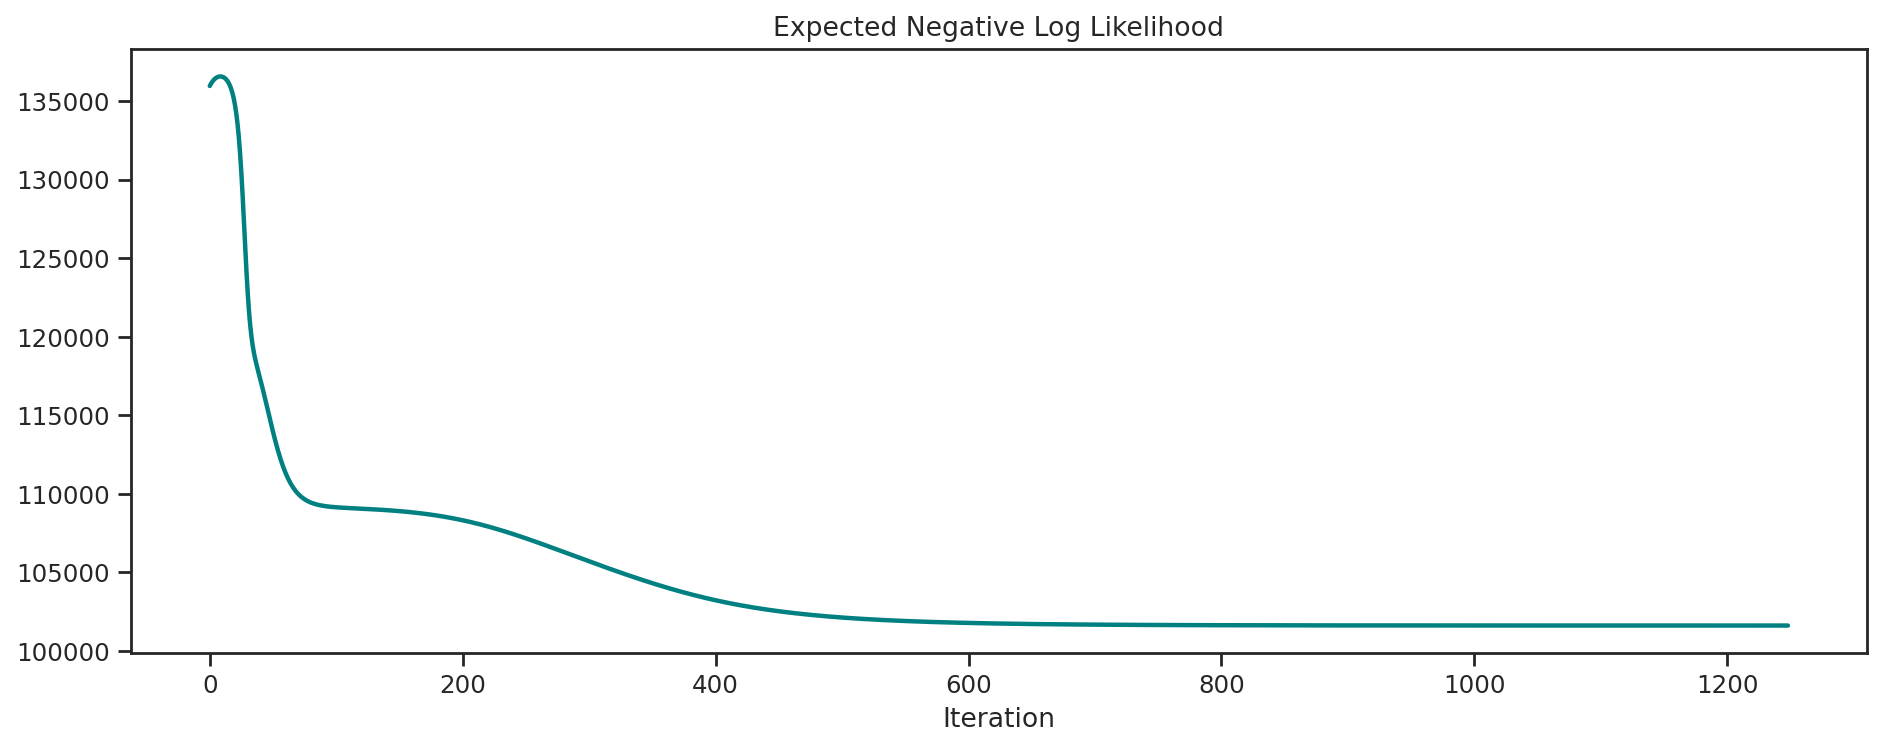

In [53]:
tf.print('True parameters\n\n{}\n\n{}\n\n{}'.format(transition_distribution, emission_params, initial_distribution), '\n\n')
tf.print('Learned parameters \n\n{}\n\n{}\n\n{}'.format(
    np.round(HMM_fit.parameters.get('transition_distribution').numpy(), 2),
    np.round(HMM_fit.parameters.get('emission_params').numpy(), 2), 
    np.round(HMM_fit.parameters.get('initial_distribution').numpy(), 2)), '\n\n')
Q_ = - HMM_fit.parameters.get('Q')
plt.figure(figsize=(14, 5))
plt.plot(Q_[1:], color="teal", linewidth=2)
plt.title("Expected Negative Log Likelihood"); plt.xlabel('Iteration'); plt.show()